# Drill 0: Test set

Now it's your turn: Apply our LSA model to the test set.  Does it identify similar sentences for components 0 through 4?  

# Drill 1: Tweaking tf-idf

Go back up to the code where we originally translated the text from words to numbers.  There are a lot of decision-points here, from the stop list to the thresholds for inclusion and exclusion, and many others as well.  We also didn't integrate spaCy, and so don't have info on lemmas or Named Entities.  Change things up a few times and see how that affects the results of the LSA.  Write up your observations and share them with your mentor.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 50)
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report

from IPython.display import display

import spacy
import re
from nltk.corpus import gutenberg, stopwords
from collections import Counter
import nltk
nltk.download('gutenberg')

from spacy.lang.en import English

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA
from sklearn import neighbors
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import LabelEncoder, Imputer
from sklearn.model_selection import train_test_split

from timeit import default_timer as timer

import os

import pydotplus
from sklearn import tree
from sklearn import preprocessing
%matplotlib inline
sns.set_style('white')

[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/morgankauffman/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [18]:
import nltk
from nltk.corpus import gutenberg
nltk.download('punkt')
nltk.download('gutenberg')
import re
from sklearn.model_selection import train_test_split

#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/morgankauffman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/morgankauffman/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present 
#once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1948
Original sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.7127450310382584, 'present': 0.701423210857947}


In [20]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])




Percent variance captured by all components: 45.20977251999653
Component 0:
" Oh !   0.999
" Oh !   0.999
" Oh !   0.999
" Oh !   0.999
" Oh !   0.999
" Oh !   0.999
" Oh !   0.999
" Oh !   0.999
" Oh !   0.999
" Oh !   0.999
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                               0.634
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                    0.585
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but I think it a bad thing ."   0.562
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elton .                        0.556
" There were misunderstanding

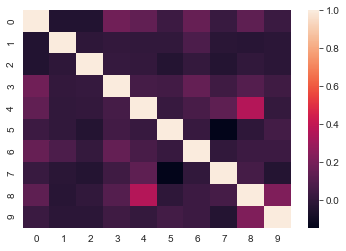

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [5]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])


# Drill 0: Test set

Now it's your turn: Apply our LSA model to the test set.  Does it identify similar sentences for components 0 through 4?  


In [3]:
### This is the original, training-set output.

Number of features: 1948
Original sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.7127450310382584, 'present': 0.701423210857947}


In [21]:
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_test_tfidf_csr = X_test_tfidf.tocsr()

#number of paragraphs
n = X_test_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_test_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_test_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present 
#once in that sentence.
print('Original sentence:', X_test[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1948
Original sentence: " And I am quite serious too , I assure you ," replied Mrs . Elton gaily , " in resolving to be always on the watch , and employing my friends to watch also , that nothing really unexceptionable may pass us ."
Tf_idf vector: {'resolving': 0.3424390305045805, 'unexceptionable': 0.3196409792117937, 'assure': 0.267729777836069, 'friends': 0.2515333740641343, 'quite': 0.1916471918420347, 'replied': 0.20315405638674577, 'watch': 0.62300800500314, 'elton': 0.16874782424809767, 'pass': 0.28445227585106625, 'really': 0.21963852817625326, 'mrs': 0.14780961753993585}


In [22]:
#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_test_lsa = lsa.fit_transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_test_lsa,index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])


Percent variance captured by all components: 49.356912922201786
Component 0:
" Oh !        1.000
" Oh !        1.000
" Me ! oh !   1.000
" Oh !        1.000
" Oh !"       1.000
" Oh !        1.000
" Oh !        1.000
" Oh !        1.000
" Oh !        1.000
" Oh !        1.000
Name: 0, dtype: float64
Component 1:
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                            0.614
After tea , Mr . and Mrs . Weston , and Mr . Elton sat down with Mr . Woodhouse to cards .                                                                                                                                                          

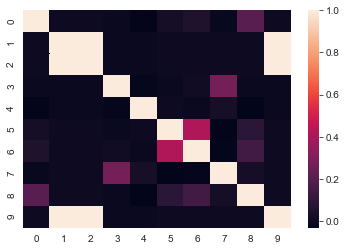

Key:
0 Mr . Woodhouse had so completely made up his mind to the visit , that in spite of the increasing coldness , he seemed to have no idea of shrinking from it , and set forward at last most punctually with his eldest daughter in his own carriage , with less apparent consciousness of the weather than either of the others ; too full of the wonder of his own going , and the pleasure it was to afford at Randalls to see that it was cold , and too well wrapt up to feel it .
1 " Oh !
2 " Oh no , no !
3 Such was Jane Fairfax ' s history .
4 " That has been a good deal the case , my dear ; but not to the degree you mention .
5 " And I am quite serious too , I assure you ," replied Mrs . Elton gaily , " in resolving to be always on the watch , and employing my friends to watch also , that nothing really unexceptionable may pass us ."
6 " And here is Mrs . Weston and Mr . Frank Churchill too ! Quite delightful ; so many friends !"
7 " You may well class the delight , the honour , and the comfo

In [23]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_test_lsa) * np.asmatrix(X_test_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_test).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])


# Drill 1: Tweaking tf-idf

Go back up to the code where we originally translated the text from words to numbers.  There are a lot of decision-points here, from the stop list to the thresholds for inclusion and exclusion, and many others as well.  We also didn't integrate spaCy, and so don't have info on lemmas or Named Entities.  Change things up a few times and see how that affects the results of the LSA.  Write up your observations and share them with your mentor.

In [59]:
def tweak_tf_idf(max_df_var, min_df_var, example_sentence, svd_size):
    X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

    vectorizer = TfidfVectorizer(max_df=max_df_var, # drop words that occur in more than half the paragraphs
                                 min_df=min_df_var, # only use words that appear at least twice
                                 stop_words='english', 
                                 lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                                 use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                                 norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                                 smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                                )


    #Applying the vectorizer
    emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
    print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

    #splitting into training and test sets
    X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


    #Reshapes the vectorizer output into something people can read
    X_train_tfidf_csr = X_train_tfidf.tocsr()

    #number of paragraphs
    n = X_train_tfidf_csr.shape[0]
    #A list of dictionaries, one per paragraph
    tfidf_bypara = [{} for _ in range(0,n)]
    #List of features
    terms = vectorizer.get_feature_names()
    #for each paragraph, lists the feature words and their tf-idf scores
    for i, j in zip(*X_train_tfidf_csr.nonzero()):
        tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

    #Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present 
    #once in that sentence.
    print('Original sentence:', X_train[example_sentence])
    print('Tf_idf vector:', tfidf_bypara[example_sentence])
    
    #Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
    svd= TruncatedSVD(svd_size)
    lsa = make_pipeline(svd, Normalizer(copy=False))
    # Run SVD on the training data, then project the training data.
    X_train_lsa = lsa.fit_transform(X_train_tfidf)

    variance_explained=svd.explained_variance_ratio_
    total_variance = variance_explained.sum()
    print("Percent variance captured by all components:",total_variance*100)

    #Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
    paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
    for i in range(5):
        print('Component {}:'.format(i))
        print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])
    
    # Compute document similarity using LSA components
    similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
    #Only taking the first 10 sentences
    sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
    #Making a plot
    ax = sns.heatmap(sim_matrix,yticklabels=range(10))
    plt.show()

    #Generating a key for the plot.
    print('Key:')
    for i in range(10):
        print(i,sim_matrix.index[i])



#### Baseline
.# of features: 1948

Tf_idf vector: {'comfortably': 0.5225597626893586, 'hear': 0.40863400822092244, 'glad': 0.4592700427052501, 'dear': 0.3220946534248823, 'settled': 0.4952530705124068}

Percent variance captured by all components: 45.20802751368376

* Component 0:  Oh!
* Component 1: Emma, Mr. Knightly, and/or Mr./Mrs. Weston mentioned
* Component 2: CHAPTER #
* Component 3: Ah!
* Component 4: short sentences around "Emma"

Number of features: 1948
Original sentence: " I am very glad , indeed , my dear , to hear she is to be so comfortably settled .
Tf_idf vector: {'comfortably': 0.5225597626893586, 'hear': 0.40863400822092244, 'glad': 0.4592700427052501, 'dear': 0.3220946534248823, 'settled': 0.4952530705124068}
Percent variance captured by all components: 45.20802751368376
Component 0:
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
" Oh !"   0.999
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                                                                                                                                                                                                                                                                                    

CHAPTER I      0.999
CHAPTER V      0.999
CHAPTER V      0.999
CHAPTER I      0.999
CHAPTER X      0.999
CHAPTER X      0.999
CHAPTER I      0.999
CHAPTER V      0.999
CHAPTER X      0.999
CHAPTER XIII   0.998
Name: 2, dtype: float64
Component 3:
But ah !   0.993
" Ah !     0.993
" Ah !"    0.993
" Ah !     0.993
But ah !   0.993
" Ah !     0.993
" Ah !     0.993
" Ah !     0.993
" Ah !     0.993
" Ah !     0.993
Name: 3, dtype: float64
Component 4:
" There were misunderstandings between them , Emma ; he said so expressly .   0.650
" Are you well , my Emma ?"                                                   0.599
Emma demurred .                                                               0.599
Emma was silenced .                                                           0.588
At first it was downright dulness to Emma .                                   0.587
" Emma , my dear Emma "                                                       0.577
Emma could not resist .                   

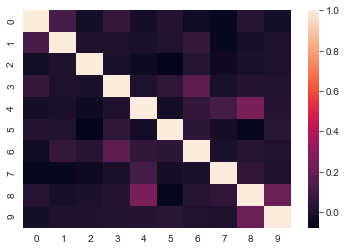

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [73]:
tweak_tf_idf(.5, 2, 22, 130) # baseline

#### max_df_var = .01
.# of features: 1832

Tf_idf vector: {'comfortably': 0.6119145988111034, 'glad': 0.5378026859197831, 'settled': 0.5799386129404677}

Percent variance captured by all components: 33.90695604924595

* Component 0: "Thank you"
* Component 1: "papa"
* Component 2: Also "papa"
* Component 3: "surprized" (yes, with a 'z')
* Component 4: "very glad"

Number of features: 1832
Original sentence: " I am very glad , indeed , my dear , to hear she is to be so comfortably settled .
Tf_idf vector: {'comfortably': 0.6119145988111034, 'glad': 0.5378026859197831, 'settled': 0.5799386129404677}
Percent variance captured by all components: 33.90695604924595
Component 0:
" Thank you .                                                                  0.995
" No , not now , I thank you .                                                 0.995
" Thank you .                                                                  0.995
" Thank you , dear Miss Woodhouse .                                            0.995
" No , I thank you .                                                           0.995
" I have not the least wish for it , I thank you ."                            0.995
" Thank you .                                                                  0.995
" Thank you , thank you . This is just what I wanted to be assured of . Oh !   0.950
" Than

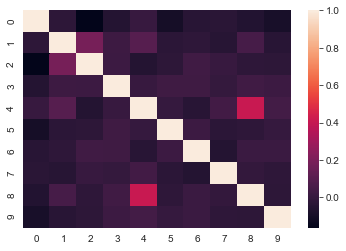

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [62]:
tweak_tf_idf(.01, 2, 22, 130)  # max_df_var = .01, min_df_var, example_sentence, svd_size

#### min_df_var = 10
.# of features: 382

Tf_idf vector: {'hear': 0.5887977744267997, 'glad': 0.6617588687321275, 'dear': 0.4641038466597991}

Percent variance captured by all components: 69.29036033348385

* Component 0:  Oh!
* Component 1: Emma
* Component 2: CHAPTER #
* Component 3: short sentences around "Emma"
* Component 4: "Mr." usually Mr. Knightley

Number of features: 382
Original sentence: " I am very glad , indeed , my dear , to hear she is to be so comfortably settled .
Tf_idf vector: {'hear': 0.5887977744267997, 'glad': 0.6617588687321275, 'dear': 0.4641038466597991}
Percent variance captured by all components: 69.29036033348385
Component 0:
" Oh !   0.998
" Oh !   0.998
" Oh !   0.998
" Oh !   0.998
" Oh !   0.998
" Oh !   0.998
" Oh !   0.998
" Oh !   0.998
" Oh !   0.998
" Oh !   0.998
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

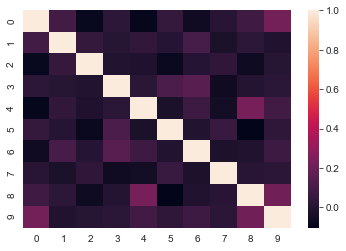

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [63]:
tweak_tf_idf(.5, 10, 22, 130)  # max_df_var, min_df_var = 10, example_sentence, svd_size

#### svd_size = 50
.# of features: 1948

Tf_idf vector: {'comfortably': 0.5225597626893586, 'hear': 0.40863400822092244, 'glad': 0.4592700427052501, 'dear': 0.3220946534248823, 'settled': 0.4952530705124068}

Percent variance captured by all components: 28.259627233623824

* Component 0:  Oh!
* Component 1: Emma, Mr. Knightly, and/or Mr./Mrs. Weston mentioned
* Component 2: CHAPTER #
* Component 3: Ah!
* Component 4: short sentences around "Emma"



Number of features: 1948
Original sentence: " I am very glad , indeed , my dear , to hear she is to be so comfortably settled .
Tf_idf vector: {'comfortably': 0.5225597626893586, 'hear': 0.40863400822092244, 'glad': 0.4592700427052501, 'dear': 0.3220946534248823, 'settled': 0.4952530705124068}
Percent variance captured by all components: 28.259627233623824
Component 0:
" Oh !    0.999
Oh !      0.999
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
" Oh !"   0.999
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
Name: 0, dtype: float64
Component 1:
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                                                                                                                                                                                                                                                                                        

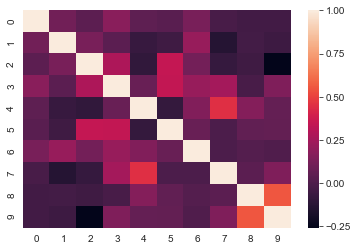

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [64]:
tweak_tf_idf(.5, 2, 22, 50)  # max_df_var, min_df_var, example_sentence, svd_size = 50

#### max_df_var = .9
.# of features: 1948

Tf_idf vector: {'comfortably': 0.5225597626893586, 'hear': 0.40863400822092244, 'glad': 0.4592700427052501, 'dear': 0.3220946534248823, 'settled': 0.4952530705124068}

Percent variance captured by all components: 45.168317019372296

* Component 0:  Oh!
* Component 1: Emma, Mr. Knightly, and/or Mr./Mrs. Weston mentioned
* Component 2: CHAPTER #
* Component 3: Ah!
* Component 4: short sentences around "Emma"

## No significant change from baseline

Number of features: 1948
Original sentence: " I am very glad , indeed , my dear , to hear she is to be so comfortably settled .
Tf_idf vector: {'comfortably': 0.5225597626893586, 'hear': 0.40863400822092244, 'glad': 0.4592700427052501, 'dear': 0.3220946534248823, 'settled': 0.4952530705124068}
Percent variance captured by all components: 45.168317019372296
Component 0:
" Oh !    0.999
" Oh !    0.999
" Oh !"   0.999
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                               0.634
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                    0.590
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightle

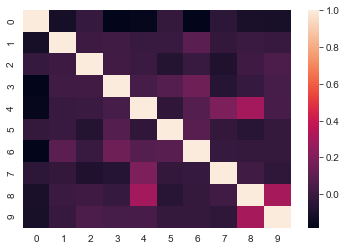

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [65]:
tweak_tf_idf(.9, 2, 22, 130)  # max_df_var = .9, min_df_var, example_sentence, svd_size

#### max_df_var = .1, min_df_var = 7
.# of features: 557

Tf_idf vector: {'hear': 0.47927836469608187, 'glad': 0.5386683207792828, 'dear': 0.3777781478416969, 'settled': 0.5808720688209875}

Percent variance captured by all components: 60.37312969776578

* Component 0:  Oh!
* Component 1: CHAPTER #
* Component 2: Mrs. Elton and/or Mrs. Weston
* Component 3: Harriet
* Component 4: "Miss", as in "Miss Fairfax"

Number of features: 557
Original sentence: " I am very glad , indeed , my dear , to hear she is to be so comfortably settled .
Tf_idf vector: {'hear': 0.47927836469608187, 'glad': 0.5386683207792828, 'dear': 0.3777781478416969, 'settled': 0.5808720688209875}
Percent variance captured by all components: 60.37312969776578
Component 0:
" Oh !    0.999
" Oh !    0.999
" Oh !"   0.999
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
Name: 0, dtype: float64
Component 1:
CHAPTER VII    1.000
CHAPTER IV     1.000
CHAPTER XIV    1.000
CHAPTER III    1.000
CHAPTER XVII   1.000
CHAPTER V      1.000
CHAPTER XVI    1.000
CHAPTER X      1.000
CHAPTER VII    1.000
CHAPTER X      1.000
Name: 1, dtype: float64
Component 2:
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elton .                                                             0.643
Miss Ba

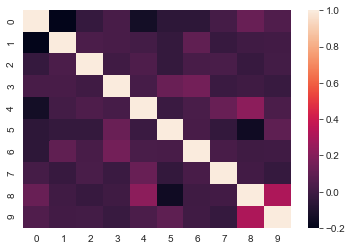

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [70]:
tweak_tf_idf(.1, 7, 22, 130)  # max_df_var = .1, min_df_var = 7, example_sentence, svd_size

#### max_df_var = .1, min_df_var = 7, svd_size = 65
Number of features: 557

Tf_idf vector: {'hear': 0.47927836469608187, 'glad': 0.5386683207792828, 'dear': 0.3777781478416969, 'settled': 0.5808720688209875}

Percent variance captured by all components: 42.756715588777375

* Component 0:  Oh!
* Component 1: CHAPTER #
* Component 2: Mrs. Elton and/or Mrs. Weston
* Component 3: Harriet
* Component 4: "Miss", as in "Miss Fairfax"

Number of features: 557
Original sentence: " I am very glad , indeed , my dear , to hear she is to be so comfortably settled .
Tf_idf vector: {'hear': 0.47927836469608187, 'glad': 0.5386683207792828, 'dear': 0.3777781478416969, 'settled': 0.5808720688209875}
Percent variance captured by all components: 42.756715588777375
Component 0:
" Oh !    0.999
" Oh !    0.999
" Oh !"   0.999
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
" Oh !"   0.999
Name: 0, dtype: float64
Component 1:
CHAPTER XI     1.000
CHAPTER V      1.000
CHAPTER II     1.000
CHAPTER XVII   1.000
CHAPTER IX     1.000
CHAPTER XIII   1.000
CHAPTER I      1.000
CHAPTER VI     1.000
CHAPTER X      1.000
CHAPTER IX     1.000
Name: 1, dtype: float64
Component 2:
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elton .                                                                         

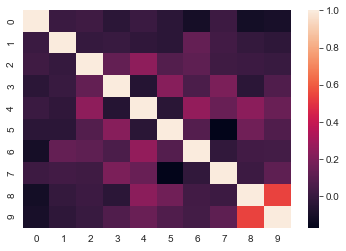

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [77]:
tweak_tf_idf(.1, 7, 22, 65)  # max_df_var = .1, min_df_var = 7, example_sentence, svd_size = 65

#### max_df_var = .1, min_df_var = 7, example_sentence, svd_size = 195
Number of features: 557

Tf_idf vector: {'hear': 0.47927836469608187, 'glad': 0.5386683207792828, 'dear': 0.3777781478416969, 'settled': 0.5808720688209875}

Percent variance captured by all components: 73.0682506621529

* Component 0:  Oh!
* Component 1: CHAPTER #
* Component 2: Mrs. Elton and/or Mrs. Weston
* Component 3: Harriet
* Component 4: "Miss", as in "Miss Fairfax"

Number of features: 557
Original sentence: " I am very glad , indeed , my dear , to hear she is to be so comfortably settled .
Tf_idf vector: {'hear': 0.47927836469608187, 'glad': 0.5386683207792828, 'dear': 0.3777781478416969, 'settled': 0.5808720688209875}
Percent variance captured by all components: 73.0682506621529
Component 0:
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
" Oh !"   0.999
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
Name: 0, dtype: float64
Component 1:
CHAPTER VII    1.000
CHAPTER II     1.000
CHAPTER X      1.000
CHAPTER VIII   1.000
CHAPTER XIV    1.000
CHAPTER X      1.000
CHAPTER IV     1.000
CHAPTER III    1.000
CHAPTER X      1.000
CHAPTER XI     1.000
Name: 1, dtype: float64
Component 2:
Miss Bates and Miss Fairfax , escorted by the two gentlemen , walked into the room ; and Mrs . Elton seemed to think it as much her duty as Mrs . Weston ' s to receive them .                                  0.631
Mrs . El

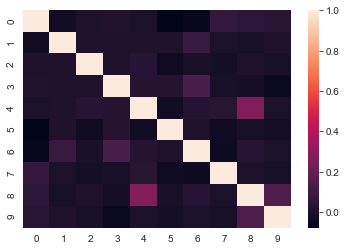

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [72]:
tweak_tf_idf(.1, 7, 22, 195)  # max_df_var = .1, min_df_var = 7, example_sentence, svd_size = 195

#### max_df_var = .5, min_df_var = 7, example_sentence, svd_size = 195
Number of features: 560

Tf_idf vector: {'hear': 0.47927836469608187, 'glad': 0.5386683207792828, 'dear': 0.3777781478416969, 'settled': 0.5808720688209875}

Percent variance captured by all components: 73.69549646305458

* Component 0:  Oh!
* Component 1: Emma
* Component 2: Chapter #
* Component 3: Short sentences related to Emma
* Component 4: "Mr." often "Mr. Knightly"

Number of features: 560
Original sentence: " I am very glad , indeed , my dear , to hear she is to be so comfortably settled .
Tf_idf vector: {'hear': 0.47927836469608187, 'glad': 0.5386683207792828, 'dear': 0.3777781478416969, 'settled': 0.5808720688209875}
Percent variance captured by all components: 73.69549646305458
Component 0:
" Oh !   0.999
" Oh !   0.999
" Oh !   0.999
" Oh !   0.999
" Oh !   0.999
" Oh !   0.999
" Oh !   0.999
" Oh !   0.999
" Oh !   0.999
" Oh !   0.999
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                               0.700
Mr . Knightley might quarrel with her , but Emma could not quarrel with herself .                                                                                          0.611
Emma found that it was not Mr . Weston ' s fault that the number of privy councillors was not yet larger .                  

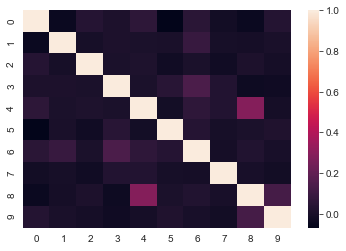

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [78]:
tweak_tf_idf(.5, 7, 22, 195)  # max_df_var = .5, min_df_var = 7, example_sentence, svd_size = 195

#### max_df_var = .1, min_df_var = 3, example_sentence, svd_size = 195
Number of features: 1355

Tf_idf vector: {'comfortably': 0.5225597626893586, 'hear': 0.40863400822092244, 'glad': 0.4592700427052501, 'dear': 0.3220946534248823, 'settled': 0.4952530705124068}

Percent variance captured by all components: 58.07732648734807

* Component 0:  Oh!
* Component 1: Mrs. Weston &/or Mrs. Elton
* Component 2: Chapter #
* Component 3: "Ah!"
* Component 4: "dear"

Number of features: 1355
Original sentence: " I am very glad , indeed , my dear , to hear she is to be so comfortably settled .
Tf_idf vector: {'comfortably': 0.5225597626893586, 'hear': 0.40863400822092244, 'glad': 0.4592700427052501, 'dear': 0.3220946534248823, 'settled': 0.4952530705124068}
Percent variance captured by all components: 58.07732648734807
Component 0:
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
" Oh !"   0.999
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
" Oh !    0.999
Name: 0, dtype: float64
Component 1:
Miss Bates and Miss Fairfax , escorted by the two gentlemen , walked into the room ; and Mrs . Elton seemed to think it as much her duty as Mrs . Weston ' s to receive them .                                                                      0.649
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elton .                                   

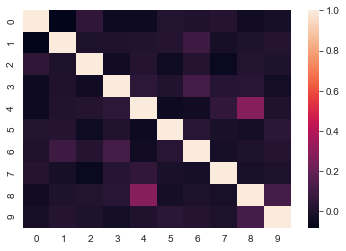

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [79]:
tweak_tf_idf(.1, 3, 22, 195)  # max_df_var = .1, min_df_var = 3, example_sentence, svd_size = 195

## Analysis

Of the major "handles" that can be manipulated in this setup, the primary ones I've identified are the max_df, min_df, and svd size/# of axes.  

_max_df_ and _min_df_ both control (from different directions) the total size of the vocabulary/word-pool that gets built.  Different combinations lead to different sets of words being selected for the first-identified topics.  Increasing the min_df leads to a significantly higher feature number and more variance being captured; max_df has less leverage on variance % and feature count, but still has a small effect.

_svd size_ plays a major role in determining the "Percent variance captured by all components."  It doesn't seem to have much effect on the actual product of the algorithm, however, though that may simply be because it's effects are found in clusters/documents that these snapshots don't look at.